# Abstract <a class="anchor" id="abstract"></a>

For this project, I will be exploring process data related to the OCME Vega shrink-wrapper; a machine heavily used in the food and beverage industry to group together loose cans and bottles into packages with plastic shrink film. Kaggle has data available for 519 different observations over the duration of a year, each reporting sensor data for 2048 time-samples for each unit that passes through the machine.

The scope of this project will be to analyze the sensor data to determine the state of the blade mechanism that makes contact with the plastic film to separate the film from a roll. If the machine runs too long without maintenance, the blade will become dull, causing the packaging to fail and release unpackaged material into the rest of the assembly line.

### Table of Contents


* [Abstract](#abstract)

* [Background](#background)

* [Problem Statement](#problemstatement)
        
* [Methods](#methods)
    * [Data Exploration](#eda)
    * [Data Restructuring](#restruct)
        * [Analyzing Mode 1](#mode1)
            * [Dividing Data into Unique Runs](#divruns)
            * [Dividing Unique Runs into Sequences](#seq)
        * [Addressing Time Series Offsets](#offsets)
            * [Using Decision Trees to Identify Sequences](#dt)
            * [Using KNN to Identify Sequences](#knn)
            * [Using Neural Networks to Identify Sequences](#neuralnet)
            * [Time Lagged Cross Correlation](#corr)
        * [Analyzing Modes 2 through 8](#mode1)
            * [Mode 2](#mode2)
            * [Mode 3](#mode3)
            * [Mode 4](#mode4)
            * [Mode 5](#mode5)
            * [Mode 6](#mode6)
            * [Mode 7](#mode7)
            * [Mode 8](#mode8)
        
* [Model Development](#models)
    * [Support Vector Machines](#svm)
    * [Neural Network](#neuralnet2)

* [Conclusion](#conclusion)                
            
* [Acknowledgments](#acknowledge)

* [References](#refs)

# Background <a class="anchor" id="background"></a>

Since the industrial revolution, machinery has been used to produce a wide variety of goods. The Ford Motor Company is credited with first utilizing assembly lines to streamline the production of the Model T vehicle back in 1913. The assembly line operated on a conveyer system, where the vehicle frame would move along from station to station as workers installed components. This conveyer system allowed Ford to drastically reduce the manufacturing time of vehicles from 12 hours per vehicle to under one hour and 33 minutes (History.com Editors, 2009). This technique allowed Ford to increase production efficiency and lower the cost of their vehicles, making them more accessible to consumers. Between 1914 and 1927, Ford was able to manufacture approximately 10 million Model T vehicles. 
In recent years, manufacturing has been dominated by machines. These machines greatly reduce the amount of human error introduced into the assembly and manufacturing process greatly as well as do tasks that are impossible or unsafe for human workers. However, they still at risk for breakdowns and part failure, which can lead to defects in products, longer waiting times for customers, unnecessary waste of raw materials, extra processing time, and in worst case scenarios, total gridlock of the production line; all of which directly impact the revenue from these businesses. 
There have been different techniques to combat these failures. In earlier times, it wasn’t uncommon to run machinery to failure. This resulted in large amounts of waste from product that ran through the machinery during the mechanical malfunctions, damage to other related components, and caused unscheduled downtime, putting the rest of the manufacturing line at risk. This is known as corrective maintenance, since an issue needed to be corrected before the machinery can return back to production. To avoid unscheduled downtime, preventive maintenance was introduced, allowing engineers to perform checks on a routine basis. This often results in issues being found before they can impact production, but often results in lower production time since machinery needs to be idled down to perform these routine checks and often no issues are found. 


# Problem Statement <a class="anchor" id="ProblemStatement"></a>

These two techniques of preventive maintenance and corrective maintenance are both extremes, with one prioritizing uptime while risking the health of machinery and product while the other prioritizes machine health over uptime. With the dawn of IoT and Industry 4.0, it is now possible to monitor manufacturing machinery to predict failures before they occur. Most manufacturing systems built today have an array of sensors that report a wide range of variables depending on what kind of work the machinery is designed to do. These sensors can report several key variables that impact production including speed of components, torque measurements, temperature measurements, vacuum levels, laser power and more.  All of this can be analyzed on-the-fly in data warehouse systems to detect anomalies and process variations before they have a chance to impact the product. 
Using this data, we can create a predictive model that can send us alarms when our process starts to trend out of spec, preventing any unnecessary unscheduled downtime and loss of material, while also reducing scheduled downtime by isolating issues down to a single source. This will ensure that our machines remain in good health while operating at the maximum possible availability.


# Methods <a class="anchor" id="methods"></a>

In this section, we will be exploring various methods of data wrangling and EDA. 

## Data Exploration <a class="anchor" id="eda"></a>

The data provided consists of 518 different observations spanning 8 seconds per observation. We can look at one of our observations to check what the data looks like

In [2]:
# Importing required libraries
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
from scipy.signal import find_peaks
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import seaborn as sns
pd.options.mode.chained_assignment = None  # default='warn'
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from scipy.signal import correlate

In [3]:
df = pd.read_csv("One Year Industrial Component Degradation/oneyeardata/01-05T140919_009_mode1.csv")
# df.head()

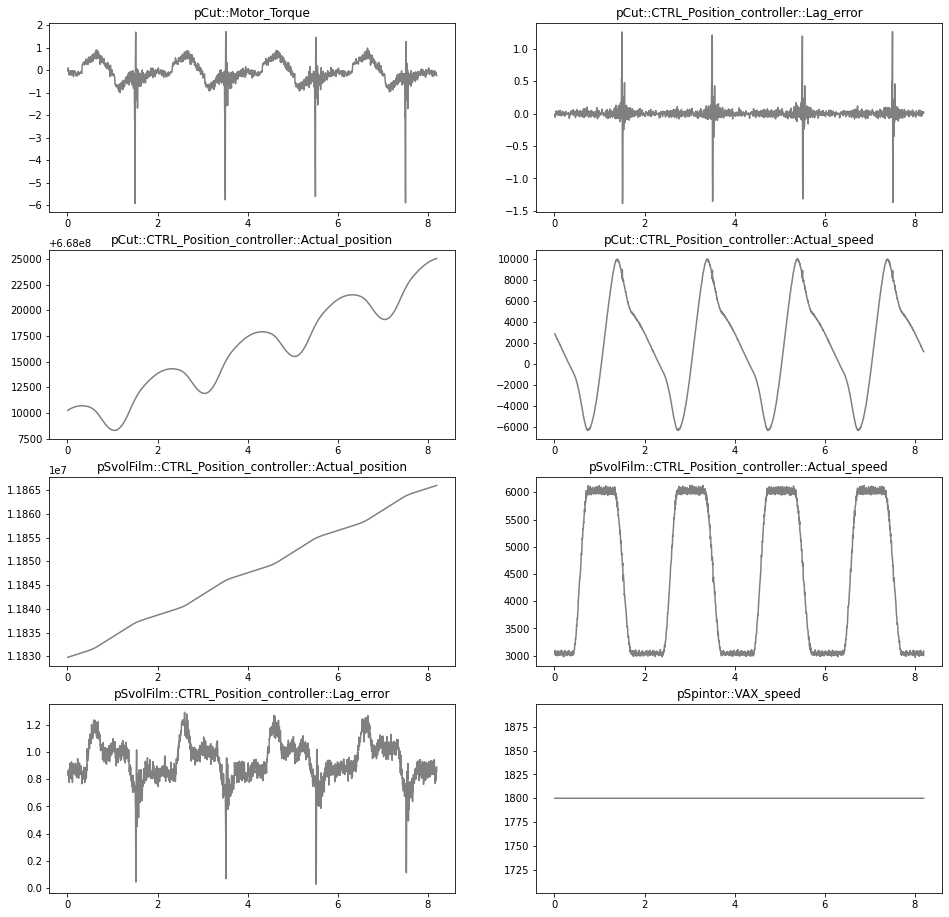

In [4]:
nums = []
for i in np.arange(0,8):
    nums.append(f"ax{i}")
fig, ((nums[0:2]),(nums[2:4]),(nums[4:6]),(nums[6:8])) = plt.subplots(4, 2,figsize=(16,16))
for i, col in zip(nums, df.columns[1:]):
    i.plot(df['timestamp'], df[col], color ="gray")
    i.title.set_text(col)
plt.show()

From this, we an see that the machinery runs through specific cycles as it runs product. The position data trends upwards as the total distance moved of the components increases. The rest of the variables remain in a stable configuration.

The machinery has 8 different operational modes, each with their own unique parameters. We can see visible differences in how the machine acts by comparing two different modes.

In [5]:
df = pd.read_csv("One Year Industrial Component Degradation/oneyeardata/02-28T151651_156_mode4.csv")
# df.head()

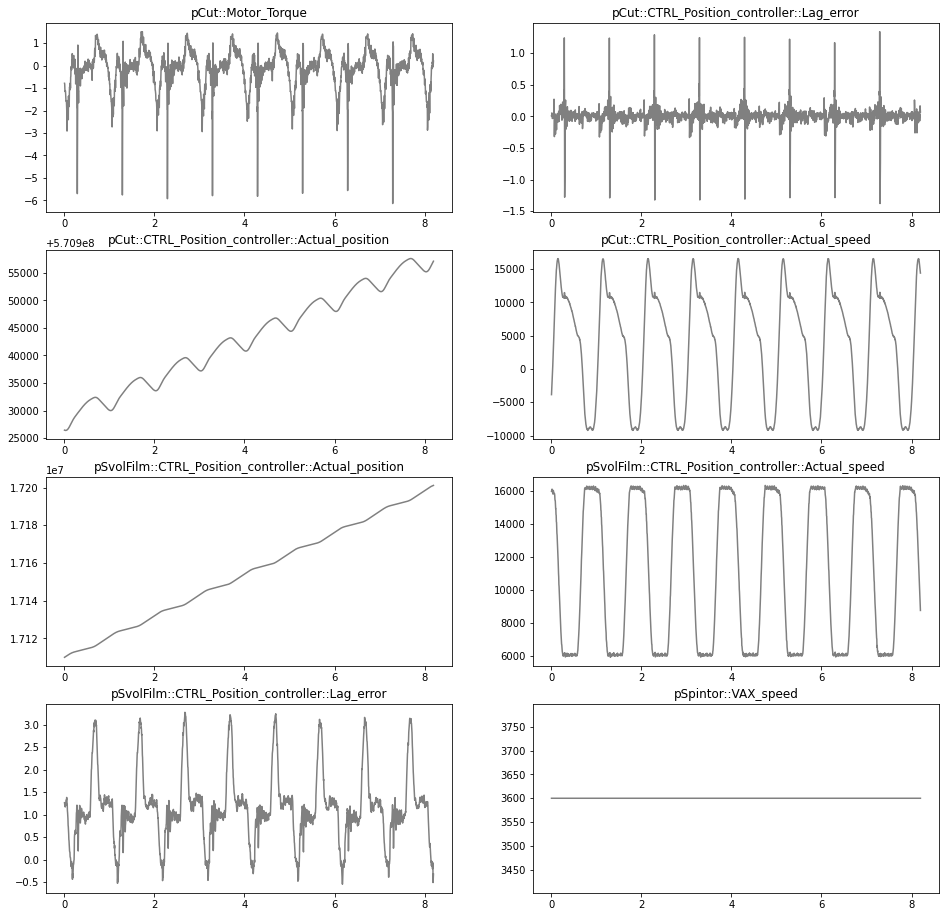

In [6]:
nums = []
for i in np.arange(0,8):
    nums.append(f"ax{i}")
fig, ((nums[0:2]),(nums[2:4]),(nums[4:6]),(nums[6:8])) = plt.subplots(4, 2,figsize=(16,16))
for i, col in zip(nums, df.columns[1:]):
    i.plot(df['timestamp'], df[col], color ="gray")
    i.title.set_text(col)
plt.show()

From this example, we can see that Mode 4 is much faster than mode 1. As of now, it may be a good idea to focus our model on one of the modes in this data first, rather than attempting to make a model that encompasses all of the modes. 

# Data Restructuring  <a class="anchor" id="restruct"></a>

## Analyzing Mode 1 <a class="anchor" id="mode1"></a>

The data seems to be cyclical, so we can attempt to slice the data into different runs and compare the unique runs against themselves. First, we need to find where the loop can start

In [152]:
df = pd.read_csv("One Year Industrial Component Degradation/oneyeardata/01-05T140919_009_mode1.csv")
# df.head()

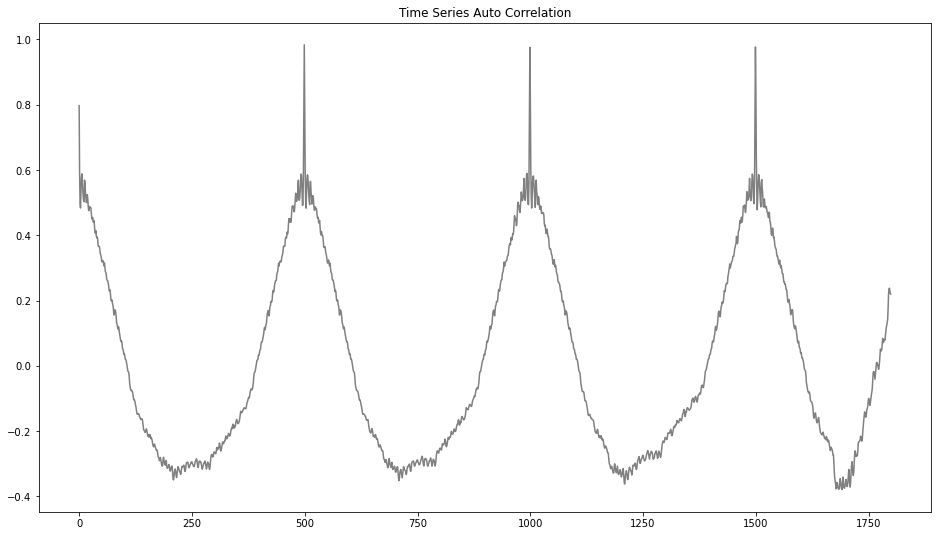

In [153]:
plt.figure(figsize=(16,9))
plt.plot([df['pCut::Motor_Torque'].autocorr(i) for i in np.arange(1,len(df['pCut::Motor_Torque'])-1)][:1800], color = 'gray')
plt.title("Time Series Auto Correlation")
plt.show()

In [154]:
from scipy.signal import find_peaks

cycles = find_peaks([df['pCut::Motor_Torque'].autocorr(i) for i in np.arange(1,len(df['pCut::Motor_Torque'])-1)], threshold=0.1)[0]
df['timestamp'].iloc[cycles[:-1]]

499     2.004000
999     4.004000
1499    6.004000
1999    8.003999
Name: timestamp, dtype: float64

From this data, we can see that the machinery cycles every 500 observations, or once every two seconds. We can confirm this visually by plotting the same instance over itself

## Dividing Data into Unique Runs <a class="anchor" id="divruns"></a>

Since our data is a continuous, looping time series, we can create another attribute in out data to split our obervation into smaller, distinct observations. 

In [155]:
# modulating timestamp and craating a subclass of each run based on the above cycle conditions

df['timestamp_new'] = (np.arange(0,2048) % (cycles[0] + 1) / (cycles[0] + 1))
df['subrun']= np.divmod(np.arange(len(df)),
                        cycles[0]+1)[0]

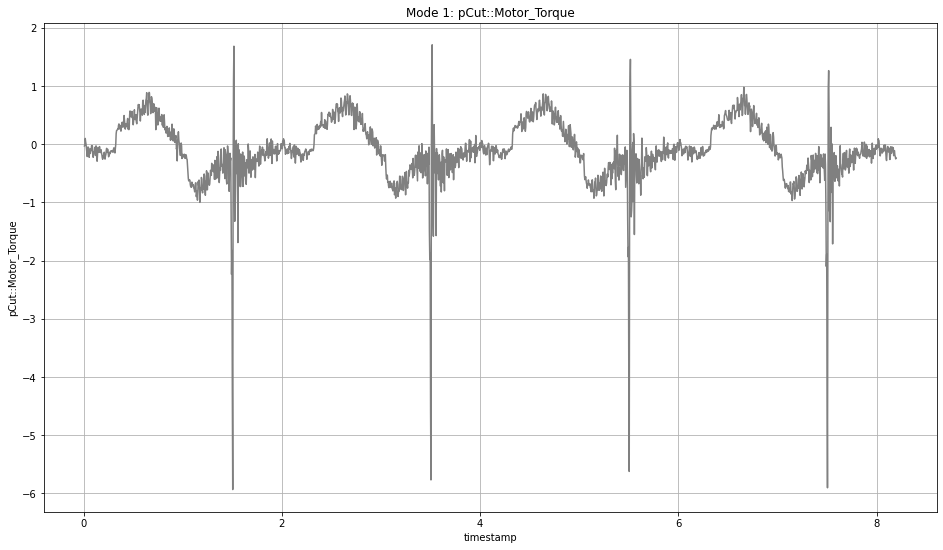

In [162]:
plt.figure(figsize=(16,9))
sns.lineplot(x = df['timestamp'], 
             y = df['pCut::Motor_Torque'], 
            # hue = df['subrun'].apply(int).apply(str)
            color = "gray")
plt.title("Mode 1: pCut::Motor_Torque")
plt.grid()
plt.show()

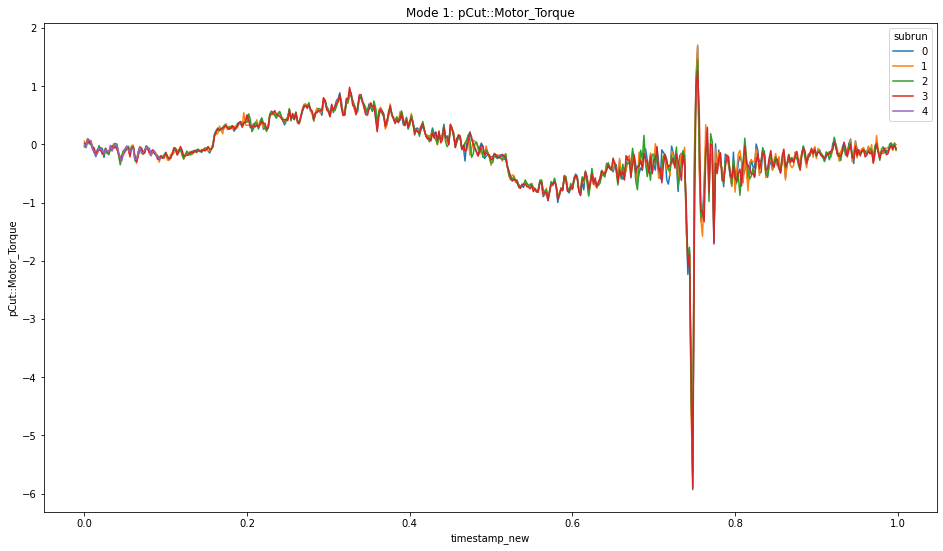

In [12]:
plt.figure(figsize=(16,9))
sns.lineplot(x = df['timestamp_new'], 
             y = df['pCut::Motor_Torque'], 
             hue = df['subrun'].apply(int).apply(str))
plt.title("Mode 1: pCut::Motor_Torque")
plt.show()

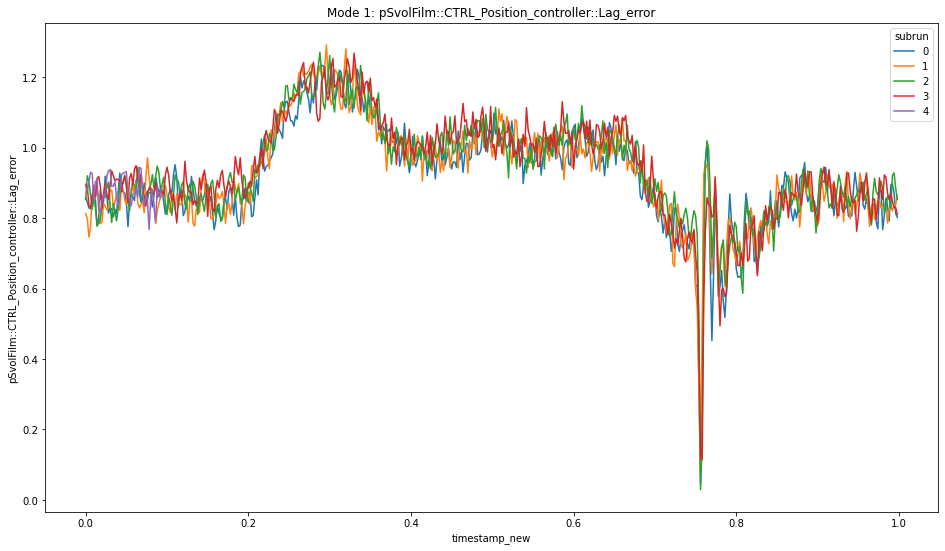

In [13]:
plt.figure(figsize=(16,9))
sns.lineplot(x = df['timestamp_new'], 
             y = df['pSvolFilm::CTRL_Position_controller::Lag_error'], 
             hue = df['subrun'].apply(int).apply(str))
plt.title("Mode 1: pSvolFilm::CTRL_Position_controller::Lag_error")
plt.show()

## Dividing Unique Runs into Sequences <a class="anchor" id="seq"></a>

We have now successfully transformed one observation into four. We can now attempt to generate summary statistics for our runs by splitting the data into distinct steps and group them together to perform some calculations. For this exercise, we can generate 8 subsets 

In [14]:
num_of_steps = 8

In [15]:
df = df[df['subrun'] != np.max(df['subrun'])]
df['sequence'] = ((np.divmod(np.arange(len(df)),(cycles[0]+1) /num_of_steps)[0]) % num_of_steps) + 1

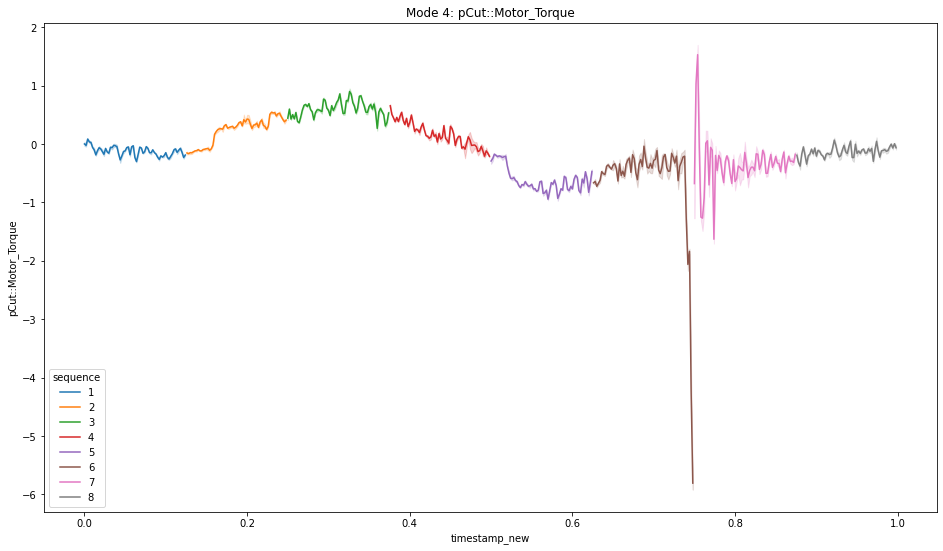

In [16]:
plt.figure(figsize=(16,9))
sns.lineplot(x = df['timestamp_new'], 
             y = df['pCut::Motor_Torque'], 
             hue = df['sequence'].apply(int).apply(str))
plt.title("Mode 4: pCut::Motor_Torque")
plt.show()

In [17]:
df_cleaned = df.groupby(['subrun','sequence']).agg({
    'pCut::Motor_Torque': ['mean', 'median', 'min', 'max', 'std', 'var', 'mad'],
    'pCut::CTRL_Position_controller::Lag_error':['mean', 'median', 'min', 'max', 'std', 'var', 'mad'],
    'pCut::CTRL_Position_controller::Actual_speed':['mean', 'median', 'min', 'max', 'std', 'var', 'mad'],
    'pSvolFilm::CTRL_Position_controller::Actual_speed':['mean', 'median', 'min', 'max', 'std', 'var', 'mad'],
    'pSvolFilm::CTRL_Position_controller::Lag_error': ['mean', 'median', 'min', 'max', 'std', 'var', 'mad'],
})

In [17]:
pd.pivot_table()

pCut::Motor_Torque                                          \
                              mean    median       min       max       std   
subrun sequence                                                              
0      1.0               -0.123347 -0.131141 -0.292287  0.099500  0.080085   
       2.0                0.225732  0.284676 -0.166666  0.571398  0.226171   
       3.0                0.596940  0.590573  0.249692  0.890311  0.137716   
       4.0                0.167694  0.148224 -0.286572  0.619400  0.207785   
       5.0               -0.623122 -0.667838 -0.999672 -0.172018  0.213719   
       6.0               -0.612995 -0.410290 -5.933069 -0.029688  0.914286   
       7.0               -0.339031 -0.344992 -1.689813  1.683595  0.438491   
       8.0               -0.130150 -0.126825 -0.375474  0.093178  0.101766   
1      1.0               -0.125344 -0.129450 -0.324417  0.093136  0.089818   
       2.0                0.222657  0.294963 -0.181394  0.551188  0.225496   
       3.0                0.590193  0.594920  0.252194  0.864933  0.137991   
       4.0                0.166037  0.151012 -0.235523  0.693541  0.214336   
       5.0               -0.614140 -0.654537 -0.926544 -0.178760  0.203424   
       6.0               -0.605958 -0.417369 -5.767601  0.009777  0.918761   
       7.0               -0.337227 -0.309133 -1.579988  1.707973  0.448419   
       8.0               -0.127316 -0.125890 -0.402344  0.149355  0.102919   
2      1.0               -0.125563 -0.125754 -0.352512  0.063767  0.084324   
       2.0                0.231681  0.290417 -0.180731  0.563209  0.227228   
       3.0                0.600786  0.603963  0.330583  0.864983  0.124247   
       4.0                0.155027  0.128537 -0.224173  0.636034  0.216025   
       5.0               -0.613897 -0.666081 -0.928130 -0.160425  0.200237   
       6.0               -0.597674 -0.398149 -5.621739  0.154038  0.873465   
       7.0               -0.346167 -0.312479 -1.551450  1.457451  0.421520   
       8.0               -0.136722 -0.133994 -0.439116  0.121894  0.099387   
3      1.0               -0.124591 -0.135184 -0.305397  0.080561  0.083607   
       2.0                0.226008  0.288197 -0.185606  0.578363  0.226729   
       3.0                0.593461  0.582666  0.216393  0.979259  0.142021   
       4.0                0.158987  0.144226 -0.203205  0.663906  0.205592   
       5.0               -0.623976 -0.677244 -0.968658 -0.155401  0.212895   
       6.0               -0.601009 -0.415979 -5.902408 -0.040388  0.875994   
       7.0               -0.359545 -0.338809 -1.712555  1.264284  0.454912   
       8.0               -0.143314 -0.140728 -0.443867  0.036896  0.089289   

                                    pCut::CTRL_Position_controller::Lag_error  \
                      var       mad                                      mean   
subrun sequence                                                                 
0      1.0       0.006414  0.066550                                 -0.002072   
       2.0       0.051153  0.185881                                 -0.001228   
       3.0       0.018966  0.107911                                  0.001462   
       4.0       0.043175  0.164021                                 -0.002467   
       5.0       0.045676  0.165455                                 -0.003804   
       6.0       0.835920  0.423464                                  0.053565   
       7.0       0.192274  0.249203                                 -0.049424   
       8.0       0.010356  0.079543                                  0.001091   
1      1.0       0.008067  0.071839                                 -0.002898   
       2.0       0.050849  0.189131                                 -0.001518   
       3.0       0.019042  0.107913                                  0.001718   
       4.0       0.045940  0.174440                                 -0.002420   
       5.0       0.041381  0.157367                                 -0

This dataframe structure will be what we will feed into our machine learning model. Before we can continue, we need to address a particular problem with the dataset we have.


# Addressing Time Series Offsets  <a class="anchor" id="offsets"></a>

The data that we currently have are not aligned properly. We won't be able to identify our sequence steps in the same method as before due to this fact. Some extra data manipulation will be required before we can add all of our data to a dataframe

In [18]:
df2 = pd.read_csv("One Year Industrial Component Degradation/oneyeardata/09-19T154332_426_mode1.csv")

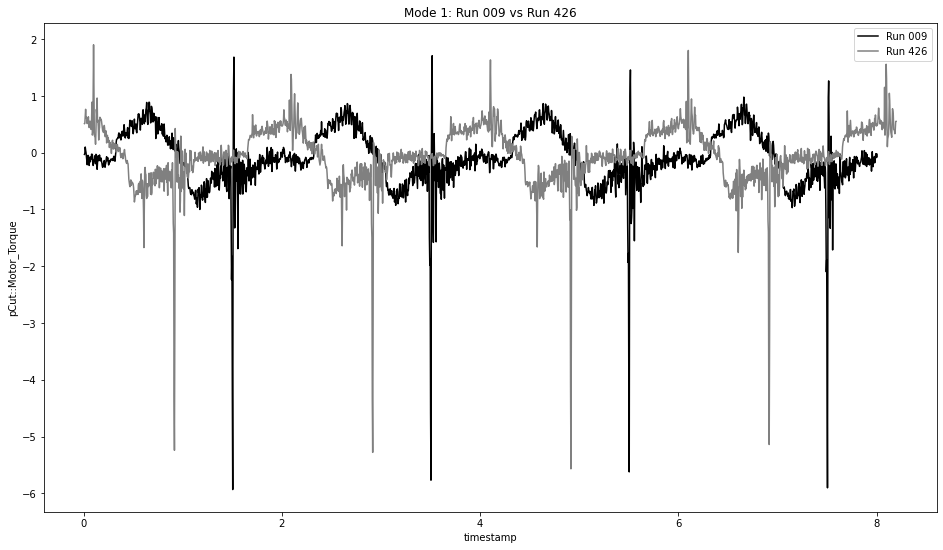

In [19]:
plt.figure(figsize=(16,9))
sns.lineplot(x = df['timestamp'], 
             y = df['pCut::Motor_Torque'], color = "black", label = "Run 009")
sns.lineplot(x = df2['timestamp'], 
             y = df2['pCut::Motor_Torque'], color="gray", label = "Run 426")
plt.title("Mode 1: Run 009 vs Run 426")
plt.legend()
plt.show()

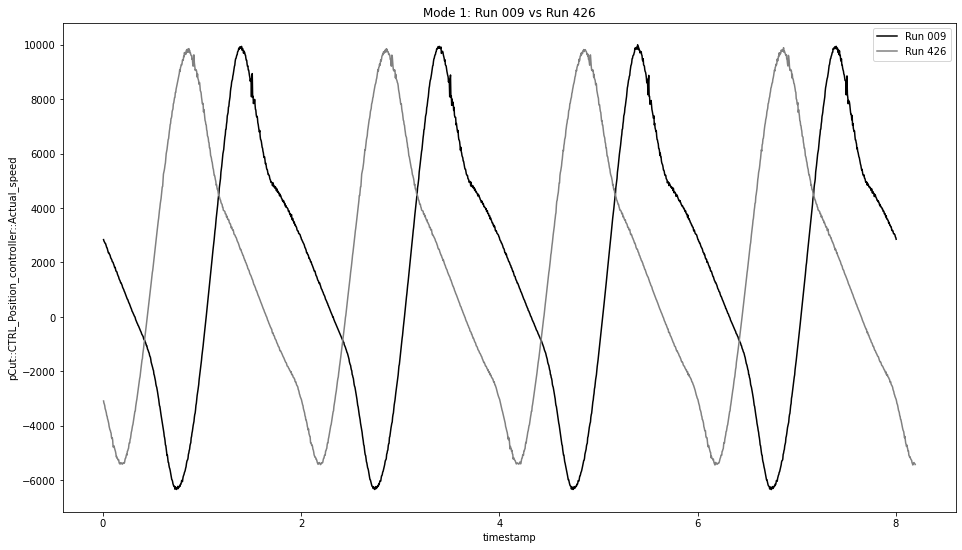

In [20]:
plt.figure(figsize=(16,9))
sns.lineplot(x = df['timestamp'], 
             y = df['pCut::CTRL_Position_controller::Actual_speed'],color = "black", label = "Run 009")
sns.lineplot(x = df2['timestamp'], 
             y = df2['pCut::CTRL_Position_controller::Actual_speed'],color="gray", label = "Run 426")
plt.title("Mode 1: Run 009 vs Run 426")
plt.legend()
plt.show()

### Using Decision Trees to Identify Sequences <a class="anchor" id="dt"></a>

Since we already defined some sequence steps for the previous run, we can attempt to create a machine learning model that can identify the sequence for the new run. Since this is mechanical data, a decision tree might be a good option.

In [21]:
X = df.drop(['timestamp',
        'pCut::CTRL_Position_controller::Actual_position', 
        'pSvolFilm::CTRL_Position_controller::Actual_position',
        'pSpintor::VAX_speed', 
        'timestamp_new',
        'subrun',
        'sequence'], axis = 1)

y = df['sequence']

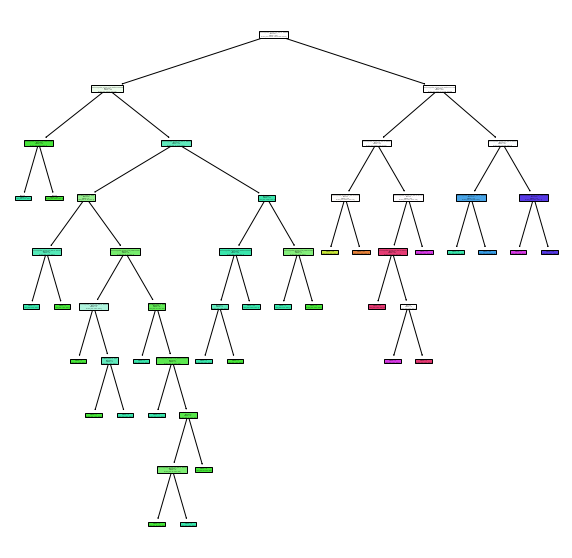

In [22]:
clf = DecisionTreeClassifier().fit(X,y)

fig = plt.figure(figsize=(10,10))
_ = tree.plot_tree(clf, 
                   feature_names=df.columns,  
                   #class_names=iris.target_names,
                   filled=True)

In [23]:
df2['sequence']= clf.predict(df2.drop(['timestamp',
                                       'pCut::CTRL_Position_controller::Actual_position', 
                                       'pSvolFilm::CTRL_Position_controller::Actual_position',
                                       'pSpintor::VAX_speed'], axis = 1))

In [24]:
color_dict = {1:"red",
          2:'orange',
          3:'yellow',
          4:'green',
          5:'cyan',
          6:"blue",
          7:'purple',
          8:'gray',
          9:'black',
          10:'pink'}

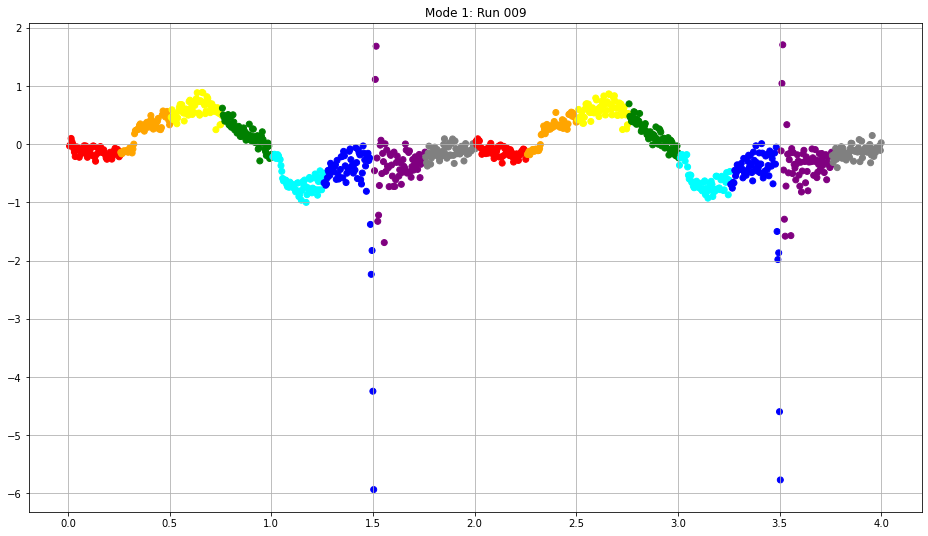

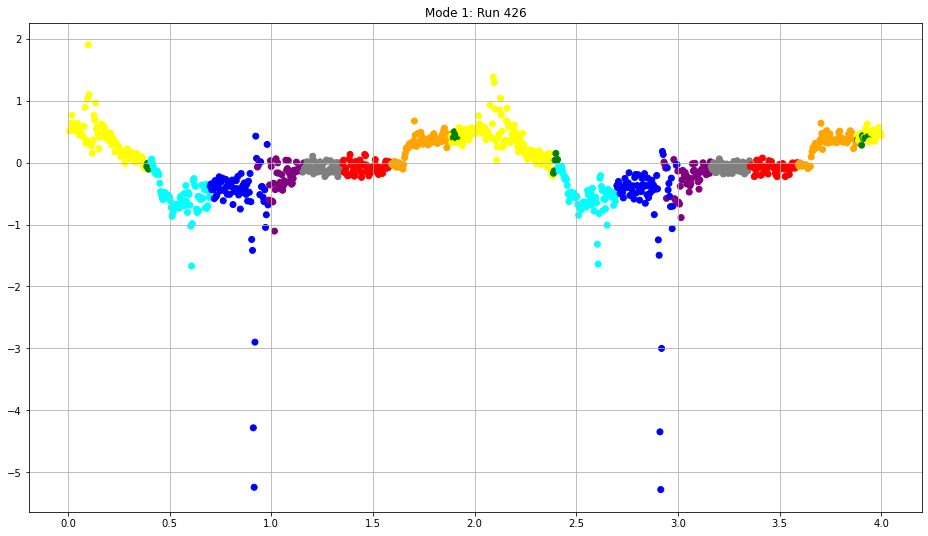

In [25]:
plt.figure(figsize=(16,9))
plt.scatter(x = df['timestamp'][:999], 
             y = df['pCut::Motor_Torque'][:999], c = df['sequence'][:999].apply(lambda x: color_dict[x]))
plt.title("Mode 1: Run 009")
plt.grid(True)

plt.figure(figsize=(16,9))
plt.scatter(x = df2['timestamp'][:999], 
             y = df2['pCut::Motor_Torque'][:999], c = df2['sequence'][:999].apply(lambda x: color_dict[x]))
plt.title("Mode 1: Run 426")
plt.grid(True)
plt.show()

Unfortunately, this method doesn't work very well. We have sequence steps that are out of order and very small, like step 4 in green. We may need to explore other options to align our dataset

### Time Lagged Cross Correlation <a class="anchor" id="corr"></a>

We can shift the time series incrementally and compare the correlation scores between them. That should help us identify the offset and use that offset the correct the time series.

In [26]:
d1 = df['pCut::Motor_Torque']
d2 = df2['pCut::Motor_Torque']

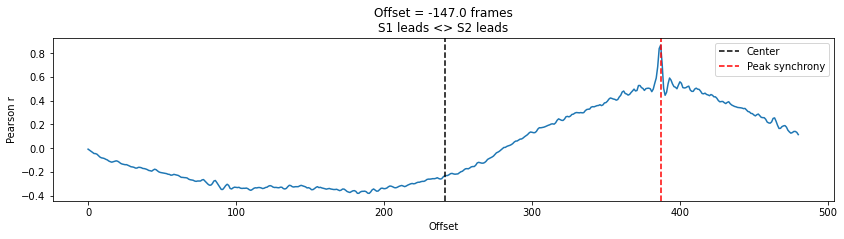

In [27]:
def crosscorr(datax, datay, lag=0, wrap=False):
    """https://towardsdatascience.com/four-ways-to-quantify-synchrony-between-time-series-data-b99136c4a9c9"""
    """ Lag-N cross correlation. 
    Shifted data filled with NaNs 
    
    Parameters
    ----------
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length
    Returns
    ----------
    crosscorr : float
    """
    if wrap:
        shiftedy = datay.shift(lag)
        shiftedy.iloc[:lag] = datay.iloc[-lag:].values
        return datax.corr(shiftedy)
    else: 
        return datax.corr(datay.shift(lag))

seconds = 8
fps = 30
rs = [crosscorr(d1,d2, lag) for lag in range(-int(seconds*fps),int(seconds*fps+1))]
offset = np.floor(len(rs)/2)-np.argmax(rs)
f,ax=plt.subplots(figsize=(14,3))
ax.plot(rs)
ax.axvline(np.ceil(len(rs)/2),color='k',linestyle='--',label='Center')
ax.axvline(np.argmax(rs),color='r',linestyle='--',label='Peak synchrony')
ax.set(title=f'Offset = {offset} frames\nS1 leads <> S2 leads', xlabel='Offset',ylabel='Pearson r')
plt.legend()
plt.show()

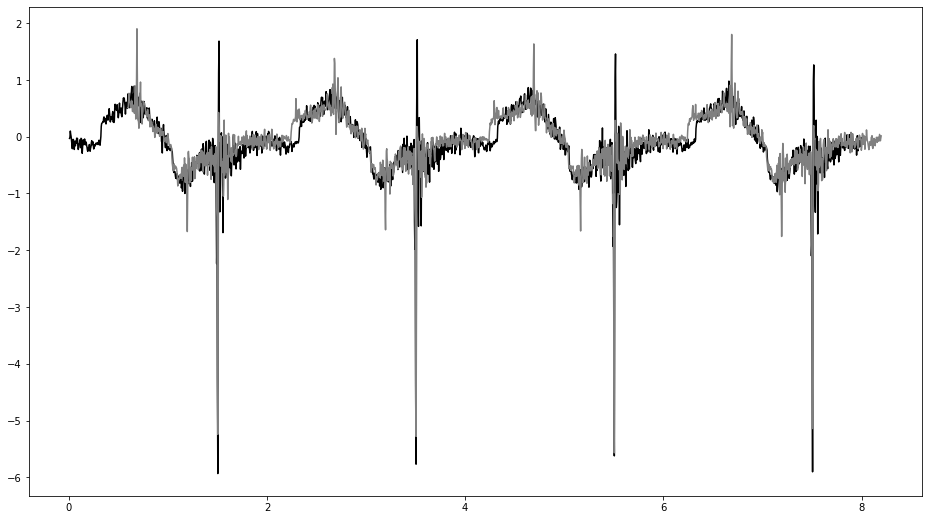

In [28]:
plt.figure(figsize=(16,9))
plt.plot(df['timestamp'],df['pCut::Motor_Torque'], color = "black")
plt.plot(df2['timestamp'][-int(offset):],df2['pCut::Motor_Torque'][:int(offset)], color = "gray")

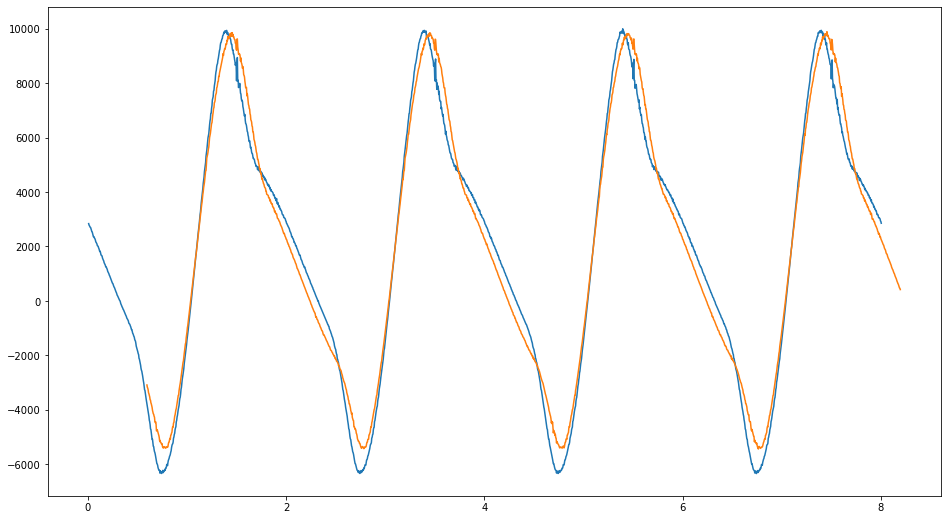

In [29]:
plt.figure(figsize=(16,9))
plt.plot(df['timestamp'],df['pCut::CTRL_Position_controller::Actual_speed'])
plt.plot(df2['timestamp'][-int(offset):],df2['pCut::CTRL_Position_controller::Actual_speed'][:int(offset)])

# END OF CURRENT WORK

In [30]:
stop

NameError: name 'stop' is not defined

In [99]:
def sequence_finder(df):
    sequences = []
    for solv, cut in zip(df['pSvolFilm::CTRL_Position_controller::Actual_speed'],
                         df['pCut::CTRL_Position_controller::Actual_speed']):
        if solv > 0.9:
            sequences.append(1)
        elif solv < 0.1:
            sequences.append(3)
        elif cut < 0.6:
            sequences.append(4)
        elif cut > 0.2:
            sequences.append(2)
        else:
            sequences.append(0)
    return sequences

In [118]:
def subrun_finder(ser):
    run_counter = []
    temp = ser[0]
    run_count = 1
    sleep = 0 
    for i in ser:
        if sleep == 0:
            if temp == 4 and i == 1:
                run_count+=1
                temp = i
                sleep = 10
        else:
            sleep -=1
        temp = i 
        run_counter.append(run_count)
    return run_counter

In [119]:
df = pd.read_csv("One Year Industrial Component Degradation/oneyeardata/01-05T140919_009_mode1.csv")
df_scaled = pd.DataFrame(MinMaxScaler().fit_transform(df), columns=df.columns)

In [120]:
df_scaled['sequence'] = sequence_finder(df_scaled)
df_scaled['subrun'] = subrun_finder(df_scaled['sequence'])

<AxesSubplot:xlabel='timestamp', ylabel='pCut::Motor_Torque'>

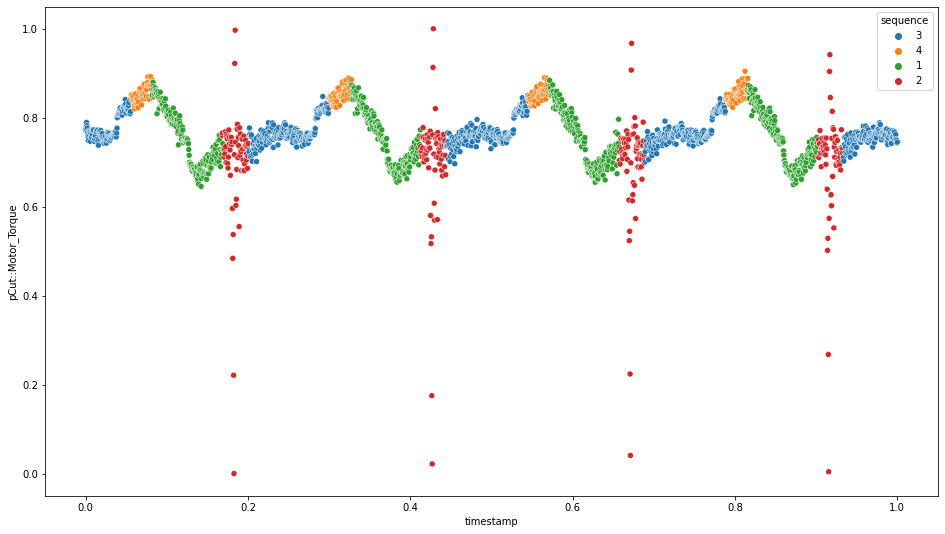

In [151]:
plt.figure(figsize=(16,9))
sns.scatterplot(x =df_scaled['timestamp'], y = df_scaled['pCut::Motor_Torque'], hue = df_scaled['sequence'].apply(str))

This technique doesn't work especially well for this data, but if we added more attributes that stabilized the data like calculating the gradients of some of the sensors, we might be able to group the data in a more efficient fashion. Another option would be to manually set groupings via "eyeballing it", but that's at a last resort

In [141]:
# Merging all observations inone one dataframe
df = pd.DataFrame()

directory = 'One Year Industrial Component Degradation/oneyeardata/'
for filename in os.listdir(directory):
    if filename.endswith(".csv"):
        print(filename)
        
        scaler = MinMaxScaler()
        temp = pd.read_csv(directory + filename)
        temp2 = pd.DataFrame(MinMaxScaler().fit_transform(temp), columns=temp.columns)
        
        temp2['sequence'] = sequence_finder(temp2)
        temp2['subrun'] = subrun_finder(temp2['sequence'])
        temp2['subrun'] = temp2['subrun'].apply(str)
        temp2['sequence'] = temp2['sequence'].apply(str)
        month = int(filename[0:2])
        day = filename[3:5]
        time = filename[6:8] +":"+ filename[8:10] +":"+ filename[10:12]
        run_number = filename[13:16]
        mode = filename[17:22]
        
        month += 2
        if month >= 13:
            month = month % 13 + 1
        date_time = datetime.datetime.strptime(f"{month}-{day} {time}", '%m-%d %H:%M:%S')
       # temp['datetime'] = date_time
        
        temp2['run_number'] = run_number
      #  temp['month'] = month
      #  temp['day'] = day
        temp2['mode'] = mode
        df = pd.concat([df,temp2])

01-04T184148_000_mode1.csv
01-04T184424_001_mode1.csv
01-04T184835_002_mode1.csv
01-04T185047_003_mode1.csv
01-04T185257_004_mode1.csv
01-05T123134_005_mode1.csv
01-05T133345_006_mode1.csv
01-05T133550_007_mode1.csv
01-05T140727_008_mode1.csv
01-05T140919_009_mode1.csv
01-05T141105_010_mode1.csv
01-05T141248_011_mode1.csv
01-05T141453_012_mode1.csv
01-05T141642_013_mode1.csv
01-05T141834_014_mode1.csv
01-05T142025_015_mode1.csv
01-05T142208_016_mode1.csv
01-05T142356_017_mode1.csv
01-05T143934_018_mode1.csv
01-06T153013_019_mode2.csv
01-06T153154_020_mode2.csv
01-06T153358_021_mode2.csv
01-06T153535_022_mode2.csv
01-06T154219_023_mode2.csv
01-06T155351_024_mode2.csv
01-06T155536_025_mode2.csv
01-06T155724_026_mode2.csv
01-06T161307_027_mode2.csv
01-06T161505_028_mode2.csv
01-06T161647_029_mode2.csv
01-06T161827_030_mode2.csv
01-06T162017_031_mode2.csv
01-06T162156_032_mode2.csv
01-06T162354_033_mode2.csv
01-06T162627_034_mode2.csv
01-06T162807_035_mode2.csv
01-06T162949_036_mode2.csv
0

06-22T142326_305_mode2.csv
06-22T143250_306_mode2.csv
06-28T140506_307_mode6.csv
06-29T085733_308_mode1.csv
06-29T110300_309_mode1.csv
06-29T112336_310_mode1.csv
06-29T115059_311_mode1.csv
06-29T121047_312_mode1.csv
07-04T095916_313_mode2.csv
07-04T101203_314_mode2.csv
07-04T104815_315_mode2.csv
07-04T113729_316_mode2.csv
07-05T085728_317_mode1.csv
07-05T102643_318_mode1.csv
07-05T110124_319_mode1.csv
07-05T112330_320_mode1.csv
07-06T091759_321_mode1.csv
07-06T094240_322_mode1.csv
07-06T100805_323_mode1.csv
07-10T155340_324_mode1.csv
07-11T114716_325_mode1.csv
07-11T115841_326_mode1.csv
07-11T135705_327_mode1.csv
07-11T144526_328_mode1.csv
07-11T152330_329_mode1.csv
07-11T155503_330_mode1.csv
07-12T170623_331_mode1.csv
07-12T171702_332_mode1.csv
07-13T105237_333_mode6.csv
07-13T110706_334_mode6.csv
07-13T112846_335_mode6.csv
07-13T124527_336_mode6.csv
07-13T151133_337_mode6.csv
07-13T153508_338_mode6.csv
07-20T111317_339_mode5.csv
07-20T113126_340_mode5.csv
07-20T121146_341_mode5.csv
0

In [131]:
df

timestamp  pCut::Motor_Torque  \
0      0.000000            0.863865   
1      0.000489            0.877710   
2      0.000977            0.889136   
3      0.001466            0.905194   
4      0.001954            0.911350   
...         ...                 ...   
2043   0.998046            0.777452   
2044   0.998534            0.776303   
2045   0.999023            0.796487   
2046   0.999511            0.762889   
2047   1.000000            0.776468   

      pCut::CTRL_Position_controller::Lag_error  \
0                                      0.587840   
1                                      0.576272   
2                                      0.566713   
3                                      0.549723   
4                                      0.555252   
...                                         ...   
2043                                   0.509660   
2044                                   0.510527   
2045                                   0.504646   
2046                                   0.536273   
2047                                   0.526012   

      pCut::CTRL_Position_controller::Actual_position  \
0                                            0.175958   
1                                            0.175731   
2                                            0.175428   
3                                            0.175125   
4                                            0.174822   
...                                               ...   
2043                                         0.939676   
2044                                         0.941904   
2045                                         0.944133   
2046                                         0.946361   
2047                                         0.948667   

      pCut::CTRL_Position_controller::Actual_speed  \
0                                         0.316307   
1                                         0.314941   
2                                         0.313849   
3                                         0.308386   
4                                         0.308113   
...                                            ...   
2043                                      0.920784   
2044                                      0.923738   
2045                                      0.932599   
2046                                      0.931794   
2047                                      0.934479   

      pSvolFilm::CTRL_Position_controller::Actual_position  \
0                                              0.000000      
1                                              0.000369      
2                                              0.000739      
3                                              0.001108      
4                                              0.001478      
...                                                 ...      
2043                                           0.997530      
2044                                           0.998139      
2045                                           0.998748      
2046                                           0.999391      
2047                                           1.000000      

      pSvolFilm::CTRL_Position_controller::Actual_speed  \
0                                              0.165899   
1                                              0.170507   
2                                              0.178802   
3                                              0.188018   
4                                              0.194470   
...                                                 ...   
2043                                           0.953846   
2044                                           0.957143   
2045                                           0.941758   
2046                                           0.956044   
2047                                           0.938461   

      pSvolFilm::CTRL_Position_controller::Lag_error  pSpintor::VAX_speed  \
0                                           0.778703       

In [142]:
tmp = df.loc[df['mode'] == 'mode1']

In [147]:
tmp2 = tmp[tmp['run_number'].isin(tmp['run_number'].sample(10))]

C:\Users\hotal\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\hotal\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\hotal\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\hotal\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


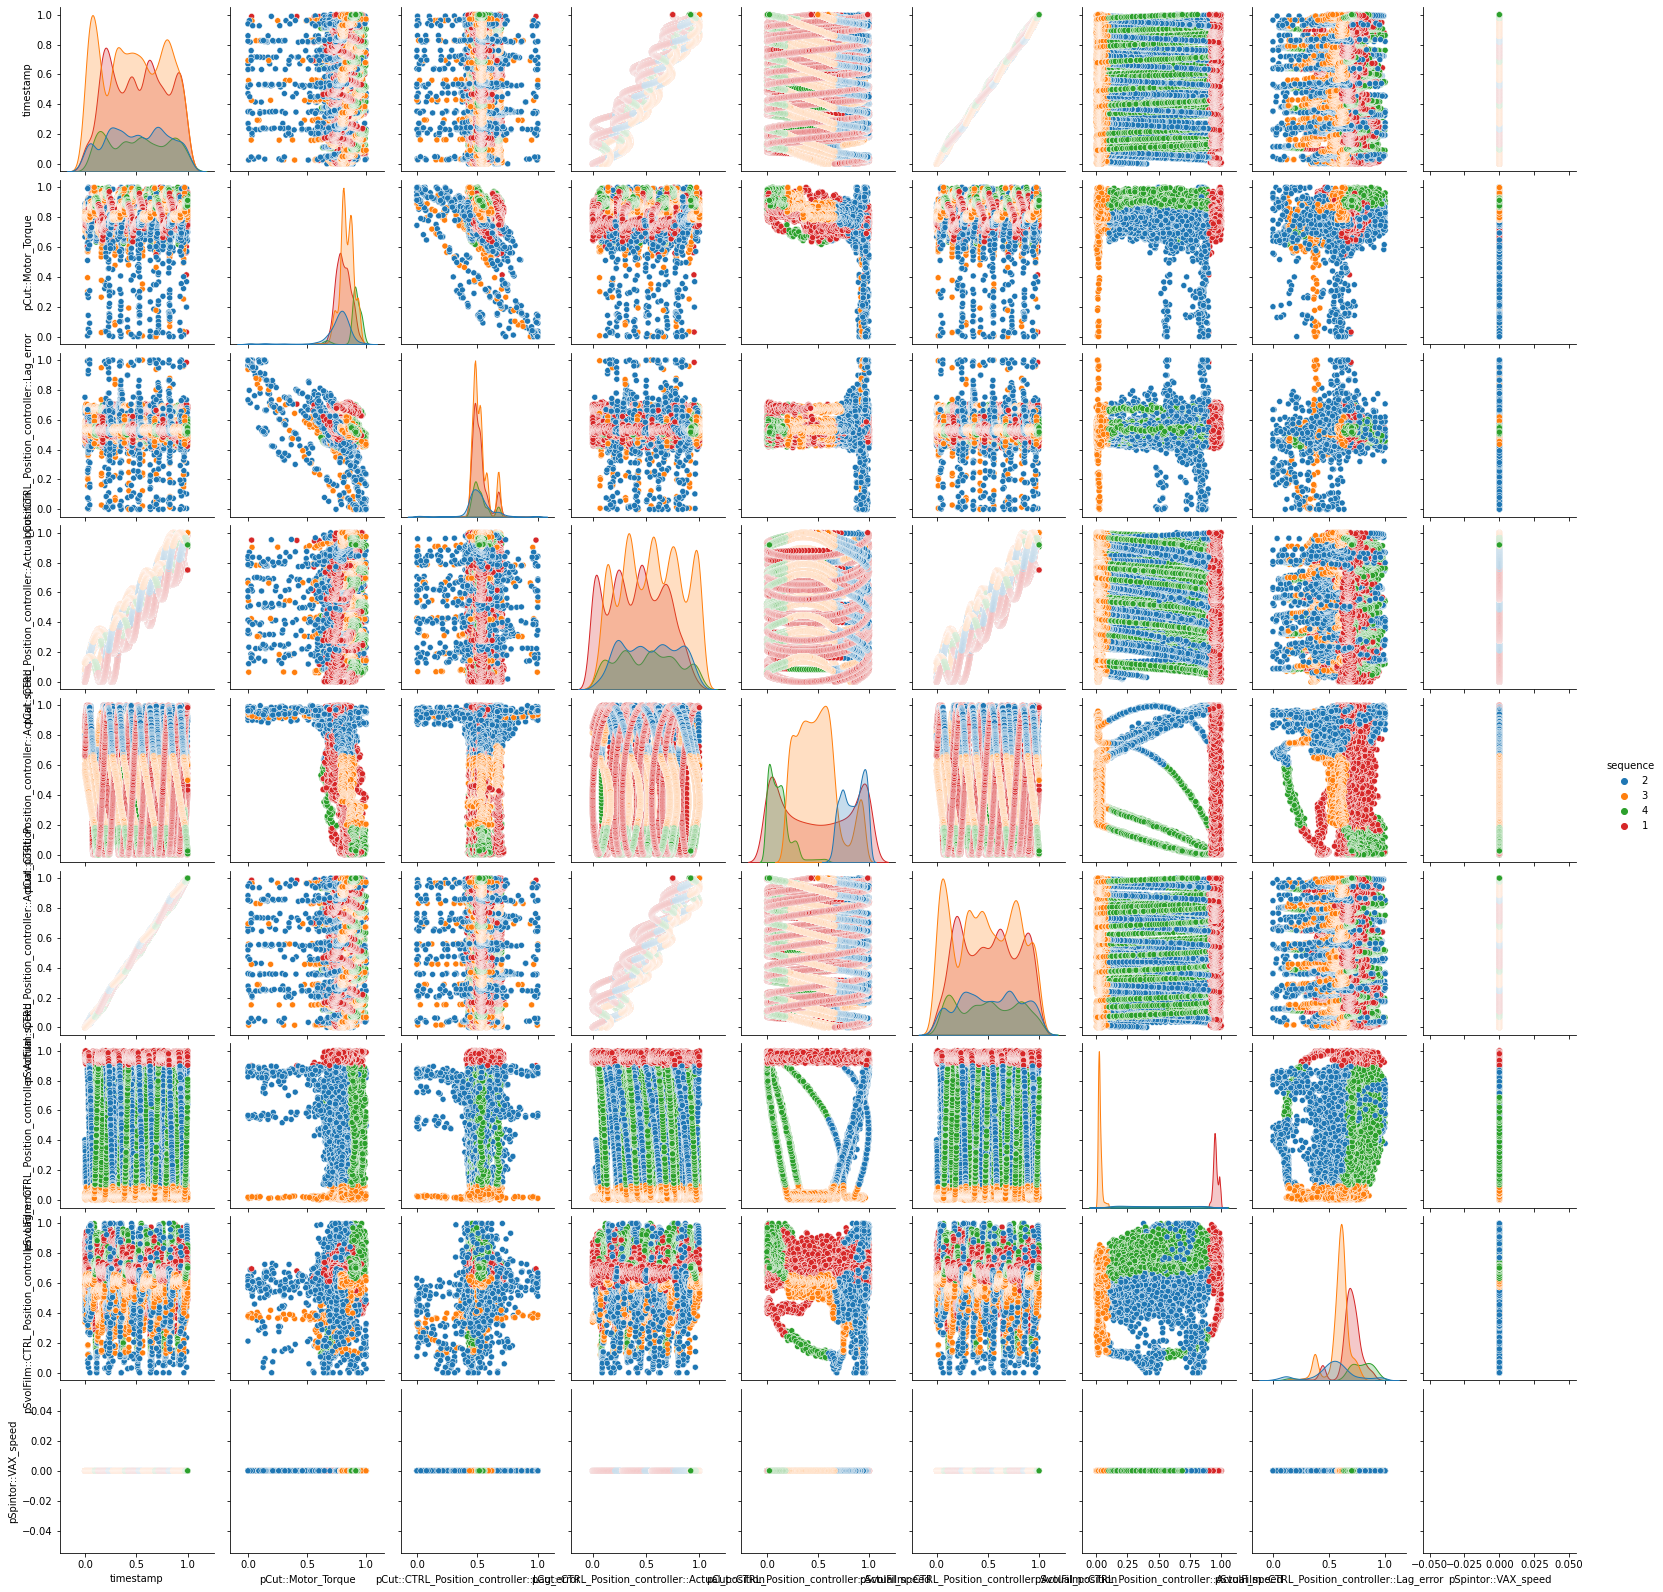

In [148]:
sns.pairplot(tmp2, hue = 'sequence')

<AxesSubplot:xlabel='pCut::CTRL_Position_controller::Actual_speed', ylabel='pSvolFilm::CTRL_Position_controller::Actual_speed'>

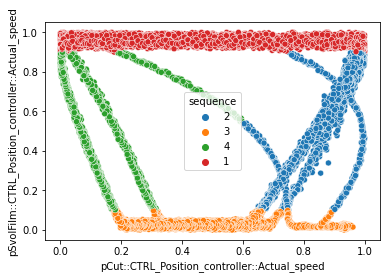

In [150]:
df.columns

sns.scatterplot(x = tmp2['pCut::CTRL_Position_controller::Actual_speed'], 
                y = tmp2['pSvolFilm::CTRL_Position_controller::Actual_speed'],
                hue = tmp2['sequence'].apply(str))
#plt.title(f"pCut Speed vs pSvolFilm Speed Correlation: {np.corrcoef(tmp2['pCut::CTRL_Position_controller::Actual_speed'], tmp2['pSvolFilm::CTRL_Position_controller::Actual_speed'])[0][1]:.4f}")

In [ ]:
main = pd.DataFrame()
for i in df[df['mode']=='mode5']['run_number'].unique():
    print(i)
    temp = df[df['run_number'] == str(i)]
    temp = substepper(temp)
#    temp = temp.groupby(['subrun','stepnum']).agg({
#    'timestamp_new':['mean'],
#    'pCut::Motor_Torque': ['mean', 'median', 'min', 'max', 'std', 'var', 'mad'],
#    'pCut::CTRL_Position_controller::Lag_error':['mean', 'median', 'min', 'max', 'std', 'var', 'mad'],
#    'pCut::CTRL_Position_controller::Actual_speed':['mean', 'median', 'min', 'max', 'std', 'var', 'mad'],
#    'pSvolFilm::CTRL_Position_controller::Actual_speed':['mean', 'median', 'min', 'max', 'std', 'var', 'mad'],
#    'pSvolFilm::CTRL_Position_controller::Lag_error': ['mean', 'median', 'min', 'max', 'std', 'var', 'mad'],})
    main = pd.concat([main,temp])
main = main.reset_index()

In [ ]:
run1 = main[main['run_number'] == '040']
run2 = main[main['run_number'] == "348"]

In [ ]:
plt.figure(figsize=(16,9))
sns.lineplot(x = run1['timestamp'], 
             y = run1['pSvolFilm::CTRL_Position_controller::Actual_speed'])

#sns.lineplot(x = test2['timestamp'], 
#             y = test2['pCut::Motor_Torque'])

sns.lineplot(x = run2['timestamp'], 
             y = run2['pSvolFilm::CTRL_Position_controller::Actual_speed'])

In [ ]:
df.groupby('labels').describe()['pCut::Motor_Torque']

scrap code below. DO NOT CRITIQUE

In [ ]:
data_grouping = list(df.groupby('month').max()['daay'].apply(lambda x:int(x)).values)
months = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
months_char = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

for _ in range(0,12):
    ind = 1
    for meas_days ,max_days,month in zip(data_grouping, months, months_char):
       # print(month,max_days,meas_days, ind, max_days >= meas_days)
        if meas_days <= max_days:
            ind += 1
        else:
            ind = 0
        if ind == 12:
            print(f"Valid Match: Data Starting in {months_char[0]}")
    months.append(months.pop(0))    
    months_char.append(months_char.pop(0))
    #print()

In [ ]:
df[df['mode'] == "mode2"]['run_number']

In [ ]:
df.columns

In [ ]:
df['pSpintor::VAX_speed'].value_counts()

In [ ]:
for i in sorted(df['mode'].unique()):
    temp = df[df['mode'] == i]
    temp = df[df['run_number'] == np.random.choice(temp['run_number'])]
    #plt.plot(temp['timestamp'], temp['pCut::Motor_Torque'])
    
    #plt.plot(temp['timestamp'], temp['pCut::Motor_Torque'])
    corrs = []
    corrs2 = []
    for x in range(1,1500):
        corrs.append(temp['pCut::Motor_Torque'].autocorr(x))
        corrs2.append(temp['pCut::CTRL_Position_controller::Lag_error'].autocorr(x))
        slope = pd.Series(np.gradient(temp['pCut::CTRL_Position_controller::Actual_speed']), temp['timestamp'], name='slope')
    plt.plot(slope)
    plt.show()
    plt.plot(temp['pCut::CTRL_Position_controller::Actual_position'])
    plt.show()
#    plt.plot(corrs2)
#    plt.title(i)
#    plt.show()
#    plt.plot(corrs)
    plt.show
    plt.title(i)
    plt.show()

In [ ]:
sorted(df['mode'].unique())

In [ ]:
test = pd.read_csv("One Year Industrial Component Degradation/oneyeardata/01-06T161505_028_mode2.csv")
test2 = pd.read_csv("One Year Industrial Component Degradation/oneyeardata/01-05T133345_006_mode1.csv")

In [ ]:
test['pCut::Motor_Torque'].plot(figsize=(16,9))

In [ ]:
plt.plot(df.iloc[find_peaks(df['pCut::Motor_Torque'])[0]]['pCut::Motor_Torque'][, tdf.iloc[find_peaks(df['pCut::Motor_Torque'])[0]]['pCut::Motor_Torque'])

In [ ]:
plt.figure(figsize=(16,9))
plt.plot(test['timestamp'], test['pCut::CTRL_Position_controller::Actual_position'])

In [ ]:
autocorr = []

for i in np.arange(0,len(test['pCut::Motor_Torque'])):
    autocorr.append(test['pCut::Motor_Torque'].autocorr(i))
    
plt.plot(test["timestamp"], autocorr)

In [ ]:
plt.plot(test['timestamp'], test['pCut::CTRL_Position_controller::Actual_position'])

In [ ]:

plt.plot(test['timestamp'], test['pSvolFilm::CTRL_Position_controller::Actual_position'])

In [ ]:
plt.plot(test['timestamp'], test['pCut::CTRL_Position_controller::Lag_error'])

In [ ]:
main.sample(10)

In [ ]:
main[main['stepnum'] == 4]['pCut::Motor_Torque']['min'].plot(figsize=(16,9))

In [ ]:
plt.figure(figsize=(16,9))
sns.histplot(x = main['pCut::Motor_Torque']['median'], hue = main['stepnum'].apply(str))

In [ ]:
main.reset_index()/

In [ ]:
clf = DecisionTreeClassifier().fit(X = df.drop(['stepnum',
                                                'subrun',
                                                'timestamp',
                                                'timestamp_new',
                                                'pCut::CTRL_Position_controller::Actual_position',
                                                'pSvolFilm::CTRL_Position_controller::Actual_position',
                                                'pSpintor::VAX_speed'], axis = 1), y =df['stepnum'])


fig = plt.figure(figsize=(100,100))
_ = tree.plot_tree(clf, 
                   feature_names=df.columns,  
                   #class_names=iris.target_names,
                   filled=True)

# Conclusion <a class="anchor" id="conclusion"></a>


# Acknowledgments <a class="anchor" id="acknowledge"></a>


# References <a class="anchor" id="refs"></a>
